# Installing TensorFlow, Keras and TensorFlow Addons

In [2]:
!pip install tensorflow
!pip install keras
!pip install tensorflow_addons

# Importing libraries and dataset

In [4]:
#import libs
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'AbstractRNNCell'

# Preparing data

In [4]:
num_classes=10
input_shape=(32,32,3)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 233s 1us/step


In [24]:
x_train=x_train[:500]
y_train=y_train[:500]
x_test=x_test[:500]
y_test=y_test[:500]

In [25]:
x_train.shape

(500, 32, 32, 3)

In [26]:
y_train.shape

(500, 1)

In [27]:
x_test.shape

(500, 32, 32, 3)

In [28]:
y_test.shape

(500, 1)

# Hyper Parameter Definition

In [43]:
#smaller learning_rate may make the model converge more slowly but result in better accuracy
#specifies the step size at which the model weights are updated during the training process
learning_rate = 0.001

#weight_decay is a regularization technique that adds a penalty to the loss function to prevent overfitting, it determines the strength og the penalty
weight_decay = 0.0001

#training data size for each iteration
batch_size = 256

#no of times the entire data will be trained
num_epochs = 30

image_size = 72 #We will resize input images to this size

#patches are smaller portions of the image that will be processed by the model
patch_size = 6 #Size of the patches to be extracted from the imput images
num_patches = (image_size//patch_size)**2
projection_dim = 64
num_heads = 4 #to determine no of attention heads in the model

#transformer_units represents no of transformer layers in form of dimensions
transformer_units = [
    projection_dim*2,
    projection_dim
] #size of transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] #size of the dense layers of the final classifier
#mlp - multi layer perceptron

# Build ViT Classifier

**Data Augmentation**

In [1]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.2),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2)
    ],
    name="data_augmentation",
)

#The mean and the variance of the training data is computed for normalization.
data_augmentation.layers[0].adapt(x_train)

NameError: name 'keras' is not defined

# MLP Architecture

In [45]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Patches

In [46]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images, 
            sizes = [1, self.patch_size, self.patch_size,1],
            strides = [1, self.patch_size, self.patch_size,1],
            rates=[1,1,1,1],
            padding="VALID" #size of images when falling short off their optimal size
        )
        patch_dim = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dim])
        return patches

# Display patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


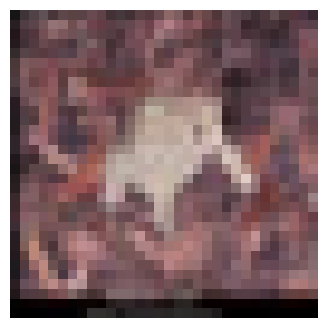

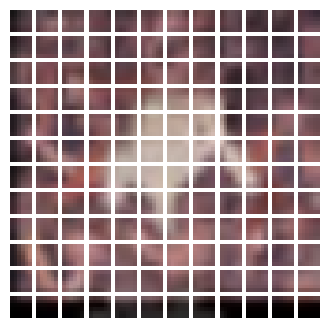

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis('off')

resized_image = tf.image.resize(tf.convert_to_tensor([image]), size=(image_size, image_size))
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n,n,i+1)
    patch_image = tf.reshape(patch, (patch_size, patch_size,3))
    plt.imshow(patch_image.numpy().astype("uint8"))
    plt.axis('off')

# Implementing the patch encoding layer

In [48]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection =layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)
    def call(self,patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# Building the ViT model

In [49]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    augmentation = data_augmentation(inputs)
    patches = Patches(patch_size)(augmentation)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=projection_dim, 
            dropout=0.1)(x1,x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x4 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x4,x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(num_classes)(features)
    model=keras.Model(inputs=inputs, outputs=logits)
    return model

# Compile, train and evaluate the model

In [50]:
def run(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    model.compile(
        optimizer=optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
          keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
          keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
          ],
    )
    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
      checkpoint_filepath,
      monitor="val_accuracy",
      save_best_only=True,
      save_weights_only=True
    )
    history = model.fit(
        x=x_train, 
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test Accuracy: {round(accuracy*100), 2}%")
    print(f"Test top 5 Accuracy: {round(top_5_accuracy*100), 2}%")
    

In [51]:
vit_classifier = create_vit_classifier()
history = run(vit_classifier)

Epoch 1/30
2/2 [==============================] - 50s 19s/step - loss: 4.7091 - accuracy: 0.1444 - top-5-accuracy: 0.5733 - val_loss: 5.8491 - val_accuracy: 0.1600 - val_top-5-accuracy: 0.6400
Epoch 2/30
2/2 [==============================] - 28s 11s/step - loss: 6.3567 - accuracy: 0.1778 - top-5-accuracy: 0.6133 - val_loss: 3.4143 - val_accuracy: 0.1600 - val_top-5-accuracy: 0.7200
Epoch 3/30
2/2 [==============================] - 24s 11s/step - loss: 4.5719 - accuracy: 0.1733 - top-5-accuracy: 0.6333 - val_loss: 3.0169 - val_accuracy: 0.1400 - val_top-5-accuracy: 0.6800
Epoch 4/30
2/2 [==============================] - 29s 14s/step - loss: 3.5077 - accuracy: 0.1933 - top-5-accuracy: 0.6378 - val_loss: 2.3526 - val_accuracy: 0.1800 - val_top-5-accuracy: 0.7000
Epoch 5/30
2/2 [==============================] - 29s 14s/step - loss: 2.9373 - accuracy: 0.2000 - top-5-accuracy: 0.7111 - val_loss: 2.0711 - val_accuracy: 0.2400 - val_top-5-accuracy: 0.7600
Epoch 6/30
2/2 [===================

In [52]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13323620541893302850
xla_global_id: -1
]


In [53]:
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck']

In [54]:
def img_predict(images, model):
    if len(images.shape)==3:
        out=model.predict(images.reshape(-1,*images.shape))
    else:
        out=model.predict(images)
    prediction=np.argmax(out, axis=1)
    img_prediction=[class_names[i] for i in prediction]
    return img_prediction

1/1 [==============================] - 3s 3s/step
['dog']


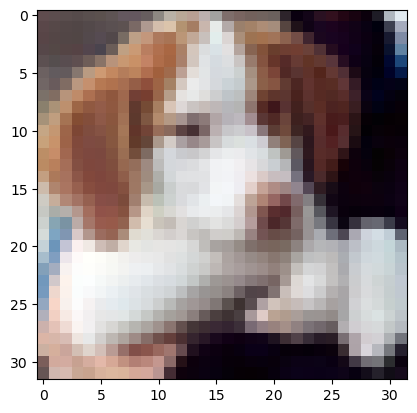

In [55]:
index=16
plt.imshow(x_test[index])
prediction=img_predict(x_test[index], vit_classifier)
print(prediction)